:Credit 1: https://www.youtube.com/watch?v=6j_qhTJgB1w

Credit 2: https://github.com/mlflow/mlflow/blob/master/examples/sklearn_elasticnet_wine/train.ipynb
# What is MLflow?

MLflow is a framework that supports the machine learning lifecycle. This means that it has components to monitor your model during training and running, ability to store models, load the model in production code and create a pipeline.

ref: https://towardsdatascience.com/getting-started-with-mlflow-52eff8c09c61

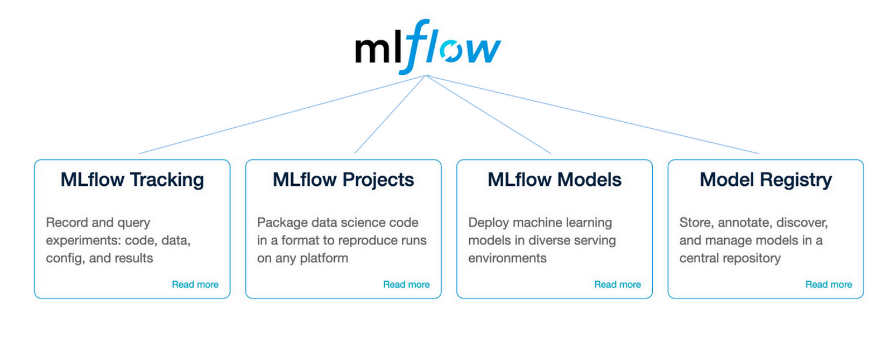

# Install mlflow

In [1]:
# !pip install mlflow --quiet --use-deprecated=legacy-resolver
!pip install mlflow --quiet

# Import libraries

In [2]:
# Importing all Libraries
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
import itertools

In [ ]:
mlflow.__version__

# Simple MLFLow Workflow for Scikit-Learn
1. Start an experiment using mlflow.start_run() which switches the context of your existing model code to enable mlflow tracking.
2. We log the run parameters with mlflow.log_param()
3. We log the model metrics (mean accuracy on the training set in this case) with mlflow.log_metric().
4. After model training and evaluation, We will log the model using mlflow.sklearn.log_model().

In [ ]:
# Load and split dataset
X, Y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("Training Data Shape: ", X_train.shape, y_train.shape)
print("Testing Data Shape: ", X_test.shape, y_test.shape)

local_registry = "sqlite:///mlruns.db"
mlflow.set_tracking_uri(local_registry)
experiment_id = mlflow.set_experiment('test_experiment')

def eval_metrics(actual, pred):
    accuracy = accuracy_score(actual, pred)
    return accuracy

def train_model(criterion, max_depth):

    # Starting the Experiement
    with mlflow.start_run():

        # Model building
        model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth,random_state=0)
        model.fit(X_train, y_train)   # Model Training
        y_pred = model.predict(X_test)  # Model Prediction on Testing data
        (accuracy) = eval_metrics(y_test, y_pred)

        print('Decision tree (criterion=%s, max_depth=%d):'%(criterion, max_depth))
        print('Accuracy: {:.4f}'.format(accuracy))

        # Logging Parameters
        mlflow.log_param("criterion", criterion)
        mlflow.log_param("max_depth", max_depth)

        # Logging Metrics
        mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))

        # Model Logging
        signature = infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(
            model,
            "model",
            signature=signature,
        )

        return model

# Train 10 decision trees with different criterion and max depth

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 4, 5],
}

all_combinations = itertools.product(
    param_grid['criterion'],
    param_grid['max_depth'],
)

for combination in all_combinations:
    criterion, max_depth = combination
    train_model(criterion, max_depth)

# MLflow Models

An MLflow Model is a standard format for packaging machine learning models that can be used in a variety of downstream tools

In [ ]:
#Search best 5 runs
best_run_df = mlflow.search_runs(order_by=['metrics.accuracy DESC'], max_results=5)
best_run_df

In [ ]:
run_id = str(best_run_df.loc[0, 'run_id'])
print('run_id: ', run_id)

run_id = str(best_run_df.loc[0, 'run_id'])
model_uri = f"runs:/{run_id}/model"
print('model_uri: ', model_uri)

In [ ]:
# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(model_uri=f"runs:/{run_id}/model")

# Predict on a Pandas DataFrame.
predicted = loaded_model.predict(pd.DataFrame(X_test))

print(classification_report(y_test, predicted, target_names=['Non-DD', 'DD'], digits=4))

# Model Registry

The MLflow Model Registry component is a centralized model store, set of APIs, and UI, to collaboratively manage the full lifecycle of an MLflow Model. It provides model lineage, model versioning, stage transitions (for example from staging to production), and annotations.

ref: https://mlflow.org/docs/latest/model-registry.html

In [ ]:
#Register best model
mlflow.register_model(model_uri=model_uri, name="breast_cancer")

# Test the model

In [ ]:
model_name = "breast_cancer"
model_version = 1

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

# Predict on a Pandas DataFrame.
predicted = loaded_model.predict(pd.DataFrame(X_test))

In [ ]:
from sklearn.metrics import  classification_report
print(classification_report(y_test, predicted, target_names=['Non-DD', 'DD'], digits=4))

# MLflow UI
After completing the model training and logging, we can track the model progress using MLFlow UI.

To enable the tracking, Navigate to the curselfrent project in Terminal and use the command below

Access this link: http://localhost:5000/

In [ ]:
!pip install pyngrok --quiet

In [ ]:
from pyngrok import ngrok
ngrok.kill()

#Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
NGROK_AUTH_TOKEN = '' # Enter your authtoken
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr='5000', proto='http', bind_tls=True)
print("MLflow Tracking UI: ", ngrok_tunnel.public_url)

In [ ]:
!mlflow ui --backend-store-uri sqlite:///mlruns.db